# The 10 Mistakes Grandmasters Never Make Twice
## by Pavel Pleskov - Data Scientist at Point API (https://pointapi.com/)

https://hackernoon.com/interview-with-kaggle-grandmaster-data-scientist-at-point-api-pavel-pleskov-cc8ca67de249

Mistakes are an essential part of the learning process

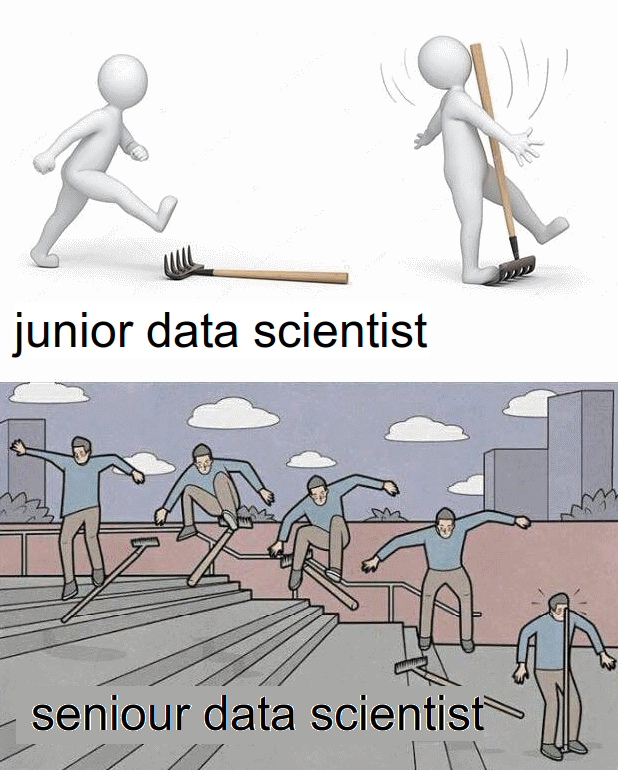

# 1. Logloss

## Definition

http://wiki.fast.ai/index.php/Log_Loss

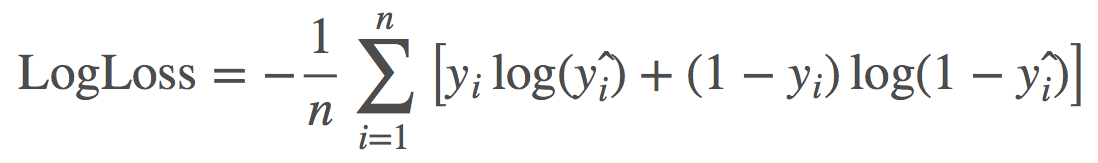

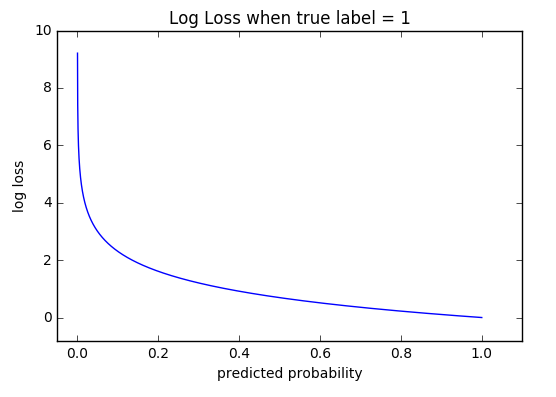

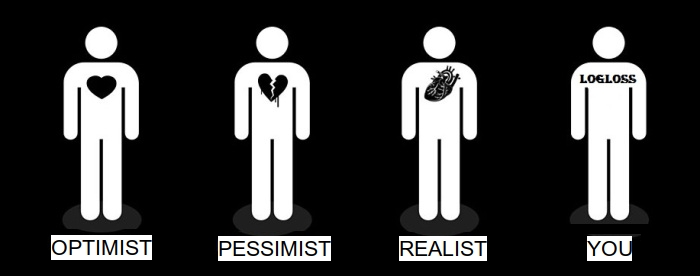

## Competitions and worst performance by GMs

### 1. Google Cloud & NCAA® ML Competition 2018-Men's:

https://www.kaggle.com/c/mens-machine-learning-competition-2018/leaderboard

In [1]:
# 799 - pleskov - 0.78794
# 909 - beluga  - 1.66835 (Gabor Fodor - Data Scientist at Emarsys)

### 2. Google Cloud & NCAA® ML Competition 2018-Women's:

https://www.kaggle.com/c/womens-machine-learning-competition-2018/leaderboard

In [2]:
# 300 - pleskov - 0.51514
# 501 - beluga  - 2.06524 

### 3. Google Cloud & NCAA® ML Competition 2019-Men's:

https://www.kaggle.com/c/mens-machine-learning-competition-2019/leaderboard

In [3]:
# 791 - pleskov - 1.00093
# 863 - NxGTR   - 12.92862  (Carlos Huertas - Senior Machine Learning Engineer at Instacart)

### 4. Google Cloud & NCAA® ML Competition 2019-Women's:

https://www.kaggle.com/c/womens-machine-learning-competition-2019/leaderboard

In [4]:
# 13 - ppleskov - 0.34414
# 300 - beluga  - 0.42821

### 5. Statoil/C-CORE Iceberg Classifier Challenge:

https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/leaderboard

In [5]:
# 13   - ppleskov - 0.10818
# 2348 - qianqian - 0.25984

## How to win?

1st place soluton 2018 for Women's league by raddar (Darius Barušauskas - Co-Founder of oxipit.ai):

https://github.com/fakyras/ncaa_women_2018/blob/master/win_ncaa.R

(python version: https://www.kaggle.com/raddar/paris-madness)

### 1. Clipping

In [6]:
### Better be safe than sorry

# Z$Pred[Z$Pred <= 0.025] = 0.025
# Z$Pred[Z$Pred >= 0.975] = 0.975

### 2. Tweaking

In [7]:
### Anomaly event happened only once before - be brave

# Z$Pred[Z$Seed1 == 16 & Z$Seed2 == 1] = 0
# Z$Pred[Z$Seed1 == 15 & Z$Seed2 == 2] = 0
# Z$Pred[Z$Seed1 == 14 & Z$Seed2 == 3] = 0
# Z$Pred[Z$Seed1 == 13 & Z$Seed2 == 4] = 0
# Z$Pred[Z$Seed1 == 1 & Z$Seed2 == 16] = 1
# Z$Pred[Z$Seed1 == 2 & Z$Seed2 == 15] = 1
# Z$Pred[Z$Seed1 == 3 & Z$Seed2 == 14] = 1
# Z$Pred[Z$Seed1 == 4 & Z$Seed2 == 13] = 1

## Practice

In [4]:
import numpy as np
import pandas as pd

from sklearn.metrics import log_loss

A toy example

In [9]:
y_true = [0,0,0,0,0]+[1,1,1,1,1]
y_pred = [0,0,0,0,0]+[1,1,1,1,0]

delta = 0.05
y_pred = np.clip(y_pred, a_min=delta, a_max=1-delta)

log_loss(y_true, y_pred, eps=1e-15)

0.34573719230419464

# 2. Different distribution of train and test sets

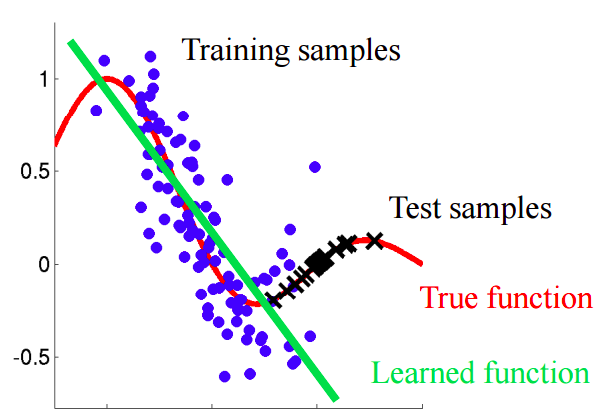

Let's make a synthetic dataset

In [42]:
import pandas as pd
import numpy as np

np.random.seed(seed=42)

mu_train = 5
si_train = 1

mu_test = 10
si_test = 2

train = pd.DataFrame()
train["animal"] = np.random.choice(["cat","dog"], 1000)
train["age"] = np.random.normal(loc=mu_train, scale=si_train, size=1000)
train["age"] = train["age"].apply(lambda x: round(x,1))

test = pd.DataFrame()
test["animal"] = np.random.choice(["cat","dog","hamster"], 200)
test["age"] = np.random.normal(loc=mu_test, scale=si_test, size=200)
test["age"] = test["age"].apply(lambda x: round(x,1))

In [43]:
train.tail()

animal  age
995    cat  4.5
996    cat  7.2
997    dog  4.4
998    dog  5.7
999    cat  5.3

In [44]:
test.tail()

animal   age
195    dog   9.2
196    dog   8.7
197    dog   5.9
198    cat  11.5
199    cat  12.5

## Numerical

In [45]:
print("stat","\t","train","\t","test")
print("min","\t",train.age.min(),"\t", test.age.min())
print("med","\t",train.age.median(),"\t", test.age.median())
print("max","\t",train.age.max(),"\t", test.age.max())

stat 	 train 	 test
min 	 2.1 	 4.3
med 	 5.0 	 10.0
max 	 8.1 	 15.3


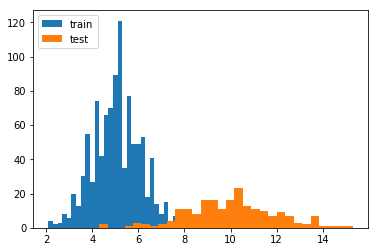

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(train.age, bins = 30, label='train')
plt.hist(test.age, bins = 30, label='test')
plt.legend(loc='upper left')

plt.show()

## Categorical

In [47]:
set(test.animal)-set(train.animal)

# replace with None or skip

{'hamster'}

## Generic case: train/test binary classification

We concatenate train and test together, and assign them the opposite labels

In [48]:
train["target"] = 1
test["target"] = 0

df = train.append(test)
df.drop("animal", axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()

age  target
1195   9.2       0
1196   8.7       0
1197   5.9       0
1198  11.5       0
1199  12.5       0

In [49]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_jobs=-1, max_depth=5, min_samples_leaf = 5, n_estimators=100)
predictions = np.zeros(len(df.target))

In [50]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, valid_idx) in enumerate(skf.split(df["age"], df.target)):
    X_train, X_valid = df.loc[train_idx, "age"], df.loc[valid_idx, "age"]
    y_train, y_valid = df.loc[train_idx, "target"], df.loc[valid_idx, "target"]
    
    X_train = np.array(X_train).reshape(-1,1)
    X_valid = np.array(X_valid).reshape(-1,1)

    rfc.fit(X_train, y_train)
    probs = rfc.predict_proba(X_valid)[:, 1] #calculating the probability
    predictions[valid_idx] = probs

In [51]:
from sklearn.metrics import roc_auc_score as auc

print('ROC-AUC for train and test distributions:', auc(df.target, predictions))

ROC-AUC for train and test distributions: 0.9759825


Train and test can be easily separated! If AUC is not around 0.5 than something is wrong.

## t-SNE example

Santander Value Prediction Challenge

https://www.kaggle.com/nanomathias/distribution-of-test-vs-training-data

# 3. When to start?

## Poll

When do you begin to actively participate in the competition?

- at the very first day
- a month after the start when all the leaks are discovered
- two weeks before the end in order to merge with somebody
- one week before the end, going solo
- one day before the end, blending kernels

## Word of advice

1. Download the data at the very first day. You may have an advantage of having the first version of it.

Examples: 
- Text Normalization Challenge - Russian Language (https://www.kaggle.com/c/text-normalization-challenge-russian-language/discussion/42505) - the test set was publicly available which allowed getting the perfect score but only after finding some discrepancies between external and internal data
- Airbus Ship Detection Challenge (https://www.kaggle.com/c/airbus-ship-detection/discussion/68042) - the data wasn't shuffled properly which helped to find some picularities. Arthur Kuzin (Head of CV at X5 Retail Group) tells about how he found the leak (Russian only) https://www.youtube.com/watch?v=MIbetMAnC04

2. Wait until first EDAs, when leaks are found, rules are clarified, and possible relaunches.

Examples:
- Santa Gift Matching Challenge (https://www.kaggle.com/c/santa-gift-matching/discussion/46236) - was relaunched because turned out to be too easy
- Toxic Comment Classification Challenge (https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/discussion/47835) - was relaunched due to test set being publicly available

3. Don't be disappointed if you started too early, and the competition has been relaunched due to the leak. You still gained a lot of experience. And things are much worse outside of Kaggle ;)

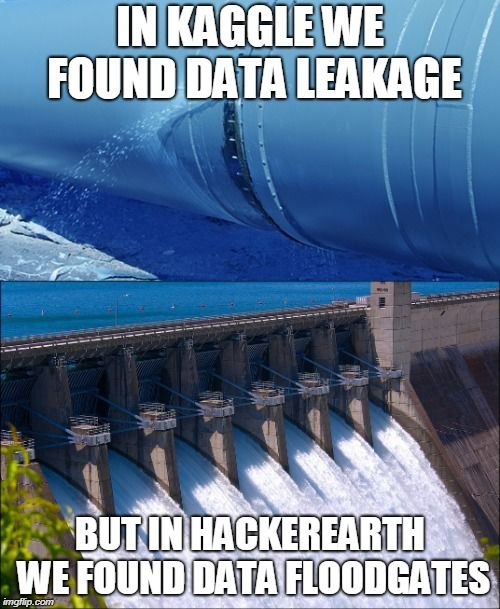

# 4. Shake-ups: CV vs LB

## Recent examples

- VSB Power Line Fault Detection (https://www.kaggle.com/c/vsb-power-line-fault-detection/leaderboard) - Sergei Fironov went from 3rd place on public to 88th on private having a perfect match between CV and LB.
- Microsoft Malware Prediction (https://www.kaggle.com/c/microsoft-malware-prediction/leaderboard) - ignoring the time structure of the data
- Google Analytics Customer Revenue Prediction (https://www.kaggle.com/c/ga-customer-revenue-prediction/leaderboard) - just a crazy competition 


## What doesn't work?

- manually changing constants to fit LB
- averaging, blending, moyen

## Rule of thumb

Trust 90% CV + 10% LB

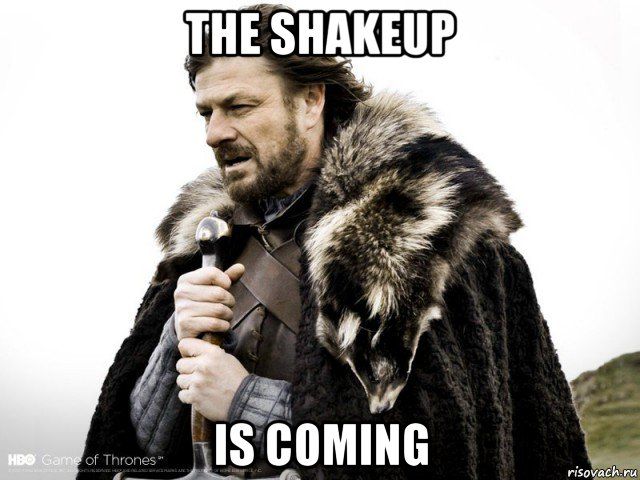

# 5. One fold or holdout validation for LGBM/XGB parameter tuning

## Motivation

- too long to wait until all folds are finished
- kernels restricted computation time
- validation seems to be aligned with LB

## Example

In [19]:
import lightgbm as lgb

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.datasets import load_breast_cancer

bunch = load_breast_cancer()

split = 300

train_label = bunch.target[:split]
test_label = bunch.target[split:]

train_set = pd.DataFrame(bunch.data[:split], columns=bunch.feature_names)
test_set = pd.DataFrame(bunch.data[split:], columns=bunch.feature_names)

test_set.tail()

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
264        21.56         22.39          142.00     1479.0          0.11100   
265        20.13         28.25          131.20     1261.0          0.09780   
266        16.60         28.08          108.30      858.1          0.08455   
267        20.60         29.33          140.10     1265.0          0.11780   
268         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
264           0.11590         0.24390              0.13890         0.1726   
265           0.10340         0.14400              0.09791         0.1752   
266           0.10230         0.09251              0.05302         0.1590   
267           0.27700         0.35140              0.15200         0.2397   
268           0.04362         0.00000              0.00000         0.1587   

     mean fractal dimension  ...  worst radius  worst texture  \
264                 0.05623  ...        25.450          26.40   
265                 0.05533  ...        23.690          38.25   
266                 0.05648  ...        18.980          34.12   
267                 0.07016  ...        25.740          39.42   
268                 0.05884  ...         9.456          30.37   

     worst perimeter  worst area  worst smoothness  worst compactness  \
264           166.10      2027.0           0.14100            0.21130   
265           155.00      1731.0           0.11660            0.19220   
266           126.70      1124.0           0.11390            0.30940   
267           184.60      1821.0           0.16500            0.86810   
268            59.16       268.6           0.08996            0.06444   

     worst concavity  worst concave points  worst symmetry  \
264           0.4107                0.2216          0.2060   
265           0.3215                0.1628          0.2572   
266           0.3403                0.1418          0.2218   
267           0.9387                0.2650          0.4087   
268           0.0000                0.0000          0.2871   

     worst fractal dimension  
264                  0.07115  
265                  0.06637  
266                  0.07820  
267                  0.12400  
268                  0.07039  

[5 rows x 30 columns]

In [20]:
param_grid = {  
              'max_depth': [3,4,5],
              'learning_rate': np.linspace(0.01, 0.1, 10),
              'lambda_l1': np.linspace(1, 10, 10),
              'lambda_l2': np.linspace(1, 10, 10)
            }

param_static = {
                'boosting_type': 'gbrt',
                'objective': 'binary',
                'metric': 'auc',
                'verbose': 0,
                'seed': 42,
                'n_jobs': -1
               }

param_list = list(ParameterSampler(param_grid, 
                                   n_iter=20))

rounded_list = [dict((k, round(v, 6)) for (k, v) in d.items())
                for d in param_list]

rounds = 1000
early_stop_rounds = 50

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### 1. Overfitting

In [21]:
%%time

results = []
for j, params in enumerate(rounded_list):    
    
    for key in param_static:
        params[key] = param_static[key]
    
    #oof = np.zeros(len(train_set))
    predictions = np.zeros(len(test_set))
    
    i = -1
    for train_index, valid_index in skf.split(train_set, train_label):
        i += 1
    
        X_train = train_set.loc[train_index]
        X_valid = train_set.loc[valid_index]

        y_train = train_label[train_index]
        y_valid = train_label[valid_index]

        d_train = lgb.Dataset(X_train, y_train)
        d_valid = lgb.Dataset(X_valid, y_valid) 

        model = lgb.train(params,
                          d_train,
                          num_boost_round=rounds,
                          valid_sets=[d_train, d_valid],
                          valid_names=['train','valid'],
                          early_stopping_rounds=early_stop_rounds,
                          verbose_eval=0) 

        y_pred = model.predict(X_valid)
        #oof[valid_index] = y_pred
        #print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))

        predictions += model.predict(test_set) 
        break
    
    res_valid = round(roc_auc_score(y_valid, y_pred), 4)
    res_test = round(roc_auc_score(test_label, predictions), 4)
    
    results.append((params, res_valid, res_test))
    for key in param_static:
        del params[key]
    
    print(j, "VALID:", res_valid, "TEST:", res_test, params)
    
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
best_params, best_valid, best_test = sorted_results[0]

print()
print("BEST VALID SCORE:", best_valid)
print("TEST SCORE:", best_test)
print("\nPARAMS:", best_params)
print()

0 VALID: 0.9892 TEST: 0.9963 {'lambda_l1': 5.0, 'max_depth': 5, 'lambda_l2': 9.0, 'learning_rate': 0.07}
1 VALID: 0.9839 TEST: 0.9925 {'lambda_l1': 9.0, 'max_depth': 4, 'lambda_l2': 6.0, 'learning_rate': 0.04}
2 VALID: 0.9849 TEST: 0.9926 {'lambda_l1': 8.0, 'max_depth': 3, 'lambda_l2': 2.0, 'learning_rate': 0.07}
3 VALID: 0.9828 TEST: 0.9922 {'lambda_l1': 10.0, 'max_depth': 5, 'lambda_l2': 10.0, 'learning_rate': 0.06}
4 VALID: 0.986 TEST: 0.9951 {'lambda_l1': 6.0, 'max_depth': 5, 'lambda_l2': 1.0, 'learning_rate': 0.03}
5 VALID: 0.9925 TEST: 0.9954 {'lambda_l1': 1.0, 'max_depth': 4, 'lambda_l2': 6.0, 'learning_rate': 0.04}
6 VALID: 0.9849 TEST: 0.9931 {'lambda_l1': 8.0, 'max_depth': 4, 'lambda_l2': 3.0, 'learning_rate': 0.05}
7 VALID: 0.9871 TEST: 0.9959 {'lambda_l1': 6.0, 'max_depth': 4, 'lambda_l2': 3.0, 'learning_rate': 0.06}
8 VALID: 0.9839 TEST: 0.9929 {'lambda_l1': 8.0, 'max_depth': 3, 'lambda_l2': 6.0, 'learning_rate': 0.06}
9 VALID: 0.9688 TEST: 0.9923 {'lambda_l1': 3.0, 'max_d

### 2. Honest approach

In [22]:
%%time

results = []
for j, params in enumerate(rounded_list):    
    
    for key in param_static:
        params[key] = param_static[key]
    
    oof = np.zeros(len(train_set))
    predictions = np.zeros(len(test_set))
    
    i = -1
    for train_index, valid_index in skf.split(train_set, train_label):
        i += 1
    
        X_train = train_set.loc[train_index]
        X_valid = train_set.loc[valid_index]

        y_train = train_label[train_index]
        y_valid = train_label[valid_index]

        d_train = lgb.Dataset(X_train, y_train)
        d_valid = lgb.Dataset(X_valid, y_valid) 

        model = lgb.train(params,
                          d_train,
                          num_boost_round=rounds,
                          valid_sets=[d_train, d_valid],
                          valid_names=['train','valid'],
                          early_stopping_rounds=early_stop_rounds,
                          verbose_eval=0) 

        y_pred = model.predict(X_valid)
        oof[valid_index] = y_pred
        #print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))

        predictions += model.predict(test_set) / skf.n_splits
    
    res_valid = round(roc_auc_score(train_label, oof), 4)
    res_test = round(roc_auc_score(test_label, predictions), 4)
    
    results.append((params, res_valid, res_test))
    for key in param_static:
        del params[key]
    
    print(j, "VALID:", res_valid, "TEST:", res_test, params)
    
sorted_results = sorted(results, key=lambda x: x[1], reverse=True)
best_params, best_valid, best_test = sorted_results[0]

print()
print("BEST CROSS-VALID SCORE:", best_valid)
print("TEST SCORE:", best_test)
print("\nPARAMS:", best_params)

print()

0 VALID: 0.9733 TEST: 0.9966 {'lambda_l1': 5.0, 'max_depth': 5, 'lambda_l2': 9.0, 'learning_rate': 0.07}
1 VALID: 0.9717 TEST: 0.995 {'lambda_l1': 9.0, 'max_depth': 4, 'lambda_l2': 6.0, 'learning_rate': 0.04}
2 VALID: 0.9724 TEST: 0.9954 {'lambda_l1': 8.0, 'max_depth': 3, 'lambda_l2': 2.0, 'learning_rate': 0.07}
3 VALID: 0.9646 TEST: 0.9946 {'lambda_l1': 10.0, 'max_depth': 5, 'lambda_l2': 10.0, 'learning_rate': 0.06}
4 VALID: 0.9641 TEST: 0.9957 {'lambda_l1': 6.0, 'max_depth': 5, 'lambda_l2': 1.0, 'learning_rate': 0.03}
5 VALID: 0.9744 TEST: 0.9968 {'lambda_l1': 1.0, 'max_depth': 4, 'lambda_l2': 6.0, 'learning_rate': 0.04}
6 VALID: 0.9727 TEST: 0.9954 {'lambda_l1': 8.0, 'max_depth': 4, 'lambda_l2': 3.0, 'learning_rate': 0.05}
7 VALID: 0.9738 TEST: 0.9963 {'lambda_l1': 6.0, 'max_depth': 4, 'lambda_l2': 3.0, 'learning_rate': 0.06}
8 VALID: 0.9728 TEST: 0.9951 {'lambda_l1': 8.0, 'max_depth': 3, 'lambda_l2': 6.0, 'learning_rate': 0.06}
9 VALID: 0.9377 TEST: 0.9931 {'lambda_l1': 3.0, 'max_d

## HPO libraries

- Hyperopt https://github.com/hyperopt/hyperopt-sklearn
- BayesianOptimization https://github.com/fmfn/BayesianOptimization

# 6. Metrics for binary classification with imbalanced classes

## Confusion matrix

- False Positive (FP): predict an event when there was no event.
- False Negative (FN): predict no event when in fact there was an event.
- True Positive (TP): predict an event when there was an event.
- True Negative (TN): predict no event when in fact there was no event.

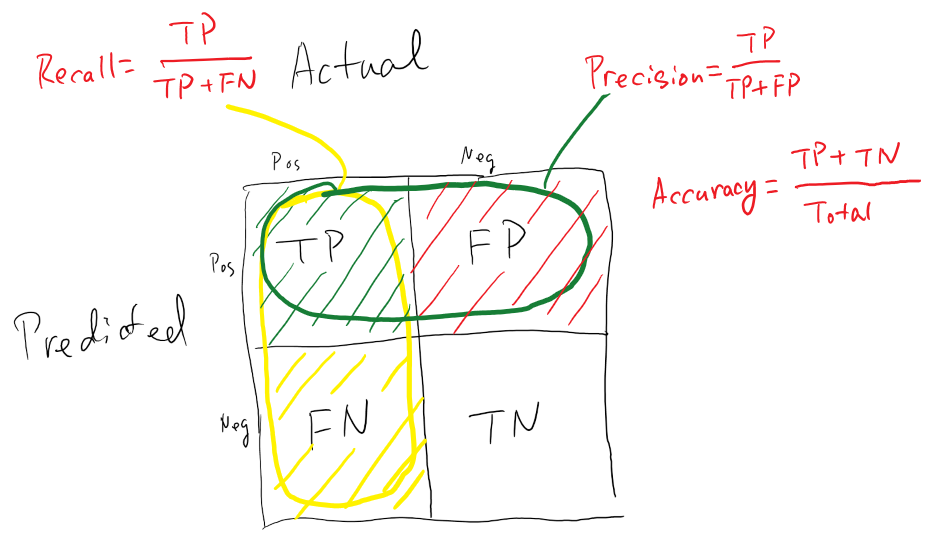

## Metrics

- Accuracy
- ROC AUC
- Precision
- Recall
- F1-score
- Cohen's kappa

## Example

Downloading synthetic data from http://archive.ics.uci.edu/ml/datasets/balance+scale

In [58]:
cols = ['var1', 'var2', 'var3', 'var4']
df = pd.read_csv("http://archive.ics.uci.edu/ml/machine-learning-databases/balance-scale/balance-scale.data",
                 names=['target'] + cols)
df.tail()

target  var1  var2  var3  var4
620      L     5     5     5     1
621      L     5     5     5     2
622      L     5     5     5     3
623      L     5     5     5     4
624      B     5     5     5     5

Making the problem binary (there were 3 classes initially)

In [59]:
df['target'] = [1 if b=='B' else 0 for b in df.target]
df['target'].value_counts()

0    576
1     49
Name: target, dtype: int64

Fitting log reg: nice accuracy!

In [229]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

y = df.target
X = df.drop('target', axis=1)
 
# Train model
reg = LogisticRegression(solver='newton-cg').fit(X, y)
 
# Predict on training set
pred_y = reg.predict_proba(X)[:,1]

print("Accuracy:", accuracy_score(y, pred_y > 0.5))

Accuracy: 0.9216


Let's look at other metrics: not so good 

In [232]:
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, precision_score, recall_score

print("ROC AUC:", round(roc_auc_score(y, pred_y), 4))
print("Precision:", round(precision_score(y, pred_y > 0.5), 4))
print("Recall:", round(recall_score(y, pred_y > 0.5), 4))
print("F1-score:", round(f1_score(y, pred_y > 0.5), 4))
print("Kappa:", round(cohen_kappa_score(y, pred_y > 0.5), 4))


ROC AUC: 0.5306
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Kappa: 0.0


/home/pavel/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pavel/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


All predictions are actually zeros :(

In [222]:
pred_y

array([0.09931327, 0.09641051, 0.09358377, 0.09083159, 0.08815247,
       0.09641051, 0.09358377, 0.09083159, 0.08815247, 0.08554494,
       0.09358377, 0.09083159, 0.08815247, 0.08554494, 0.08300751,
       0.09083159, 0.08815247, 0.08554494, 0.08300751, 0.08053873,
       0.08815247, 0.08554494, 0.08300751, 0.08053873, 0.07813711,
       0.09641051, 0.09358377, 0.09083159, 0.08815247, 0.08554494,
       0.09358377, 0.09083159, 0.08815247, 0.08554494, 0.08300752,
       0.09083159, 0.08815247, 0.08554494, 0.08300751, 0.08053873,
       0.08815247, 0.08554494, 0.08300751, 0.08053873, 0.07813711,
       0.08554494, 0.08300751, 0.08053873, 0.07813711, 0.0758012 ,
       0.09358377, 0.09083159, 0.08815247, 0.08554494, 0.08300752,
       0.09083159, 0.08815247, 0.08554494, 0.08300752, 0.08053873,
       0.08815247, 0.08554494, 0.08300751, 0.08053873, 0.07813711,
       0.08554494, 0.08300751, 0.08053873, 0.07813711, 0.0758012 ,
       0.08300751, 0.08053873, 0.07813711, 0.0758012 , 0.07352

Let's fit RF

In [235]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df))

for train_index, valid_index in skf.split(df, df.target):

    X_train = df.loc[train_index, cols]
    X_valid = df.loc[valid_index, cols]

    y_train = df.loc[train_index, "target"]
    y_valid = df.loc[valid_index, "target"]

    d_train = lgb.Dataset(X_train, y_train)
    d_valid = lgb.Dataset(X_valid, y_valid) 

    model = RandomForestClassifier(n_estimators=100,
                                   max_depth=5,
                                   criterion='gini', # Gini = 2 × AUC − 1
                                   random_state=42,
                                   class_weight={0:1,1:10})
    model.fit(X_train, y_train) 

    y_pred = model.predict(X_valid)
    oof[valid_index] = y_pred

print("OOF results:\n")
print(" Accuracy:", round(accuracy_score(df.target, oof > 0.5), 4))
print(" ROC AUC:", round(roc_auc_score(df.target, oof), 4))
print(" Precision:", round(precision_score(df.target, oof > 0.5), 4))
print(" Recall:", round(recall_score(df.target, oof > 0.5), 4))
print(" F1-score:", round(f1_score(df.target, oof), 4))
print(" Kappa:", round(cohen_kappa_score(df.target, oof), 4))
print()
print("Number of non-zero predictions:",sum(oof > 0.5))

OOF results:

 Accuracy: 0.88
 ROC AUC: 0.4868
 Precision: 0.0357
 Recall: 0.0204
 F1-score: 0.026
 Kappa: -0.0329

Number of non-zero predictions: 28


Some metrics seem to become worse but at least we have a non-trivial model!

## Homework

- This analysis was inspired by https://elitedatascience.com/imbalanced-classes
- Check if you can spot some flaws in their solution :)

# 7. Data/code maintaining culture

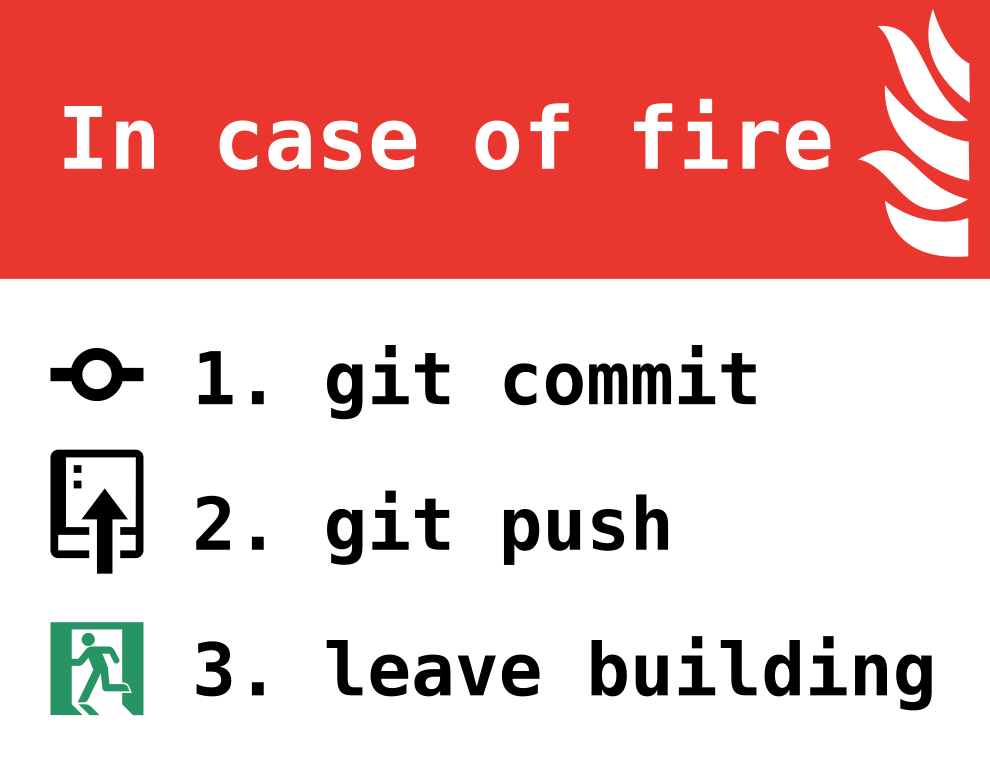

## Version control

Code:
- GitHub https://github.com/
- GitLab https://gitlab.com/

Data:
- Gdrive https://github.com/gdrive-org/gdrive
- AWS S3 https://docs.aws.amazon.com/en_us/AmazonS3/latest/dev/Versioning.html

Experiments (https://www.inovex.de/blog/machine-learning-model-management/):
- DVS https://dvc.org/
- mlFlow https://mlflow.org/
- Sacred https://github.com/IDSIA/sacred

## Jupyter notebooks

- save different experiments in separate notebooks
- give sound names to notebooks

## Reproducibility: fixing seeds

In [23]:
import torch
import random
import numpy as np
import tensorflow as tf
from keras import backend as K

import torch.multiprocessing as mp
# do not use python multiprocessing

random.seed(42)
np.random.seed(42)

# https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
tf.set_random_seed(42)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


## Teamwork: fixing folds

In [24]:
''' https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html '''

from sklearn.model_selection import StratifiedKFold

X = np.array(range(10))
y = np.array([0] * 5 + [1] * 5)

skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
skf.get_n_splits(X, y)
print(skf, "\n")  

for train_index, valid_index in skf.split(X, y):
    print("TRAIN:", train_index, "VALID:", valid_index)
    X_train, X_test = X[train_index], X[valid_index]
    y_train, y_test = y[train_index], y[valid_index]

StratifiedKFold(n_splits=5, random_state=42, shuffle=True) 

TRAIN: [0 2 3 4 5 7 8 9] VALID: [1 6]
TRAIN: [0 1 2 3 5 6 7 8] VALID: [4 9]
TRAIN: [0 1 3 4 5 6 8 9] VALID: [2 7]
TRAIN: [1 2 3 4 6 7 8 9] VALID: [0 5]
TRAIN: [0 1 2 4 5 6 7 9] VALID: [3 8]


## Teamwork: version matching

In [25]:
import sys

import pandas as pd
import numpy as np

import torch
import tensorflow as tf

print(sys.version)
print()
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("torch:", torch.__version__)
print("tensorflow:", tf.__version__)

3.5.6 |Anaconda custom (64-bit)| (default, Aug 26 2018, 21:41:56) 
[GCC 7.3.0]

pandas: 0.24.2
numpy: 1.16.2
torch: 1.0.1.post2
tensorflow: 1.3.0


# 8. Overfitting logistic regression

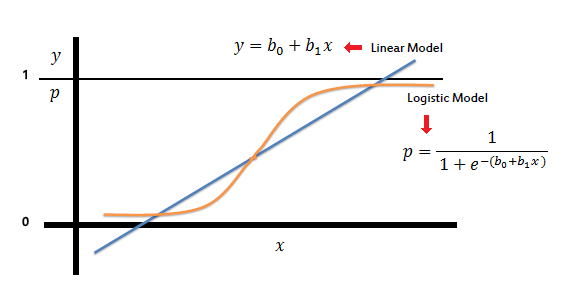

Downloading the data

In [394]:
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip

In [395]:
#!unzip occupancy_data.zip

In [475]:
import pandas as pd
df = pd.read_csv("datatraining.txt")
df.drop("date", axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)
df.tail()

Temperature  Humidity  Light         CO2  HumidityRatio  Occupancy
8138        21.05   36.0975  433.0  787.250000       0.005579          1
8139        21.05   35.9950  433.0  789.500000       0.005563          1
8140        21.10   36.0950  433.0  798.500000       0.005596          1
8141        21.10   36.2600  433.0  820.333333       0.005621          1
8142        21.10   36.2000  447.0  821.000000       0.005612          1

Target is balanced enough 

In [476]:
df.Occupancy.value_counts()

0    6414
1    1729
Name: Occupancy, dtype: int64

In [477]:
dt = pd.read_csv("datatest.txt")
dt.drop("date", axis=1, inplace=True)
dt.reset_index(drop=True, inplace=True)
dt.tail()

Temperature   Humidity  Light      CO2  HumidityRatio  Occupancy
2660    24.290000  25.700000  808.0  1150.25       0.004829          1
2661    24.330000  25.736000  809.8  1129.20       0.004848          1
2662    24.330000  25.700000  817.0  1125.80       0.004841          1
2663    24.356667  25.700000  813.0  1123.00       0.004849          1
2664    24.408333  25.681667  798.0  1124.00       0.004860          1

In [478]:
cols = list(df.columns)
cols.remove("Occupancy")
cols

['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']

In [484]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

scaler = StandardScaler()

df[cols] = scaler.fit_transform(df[cols])
dt[cols] = scaler.transform(dt[cols])

CV and TEST results are aligned

In [495]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = "clf_0"

for c in np.linspace(1, 100, 10):

    df[model] = 0
    dt[model] = 0

    i = -1
    for train_index, valid_index in skf.split(df[cols], df.Occupancy):
        i+=1

        X_train = df.loc[train_index, cols]
        X_valid = df.loc[valid_index, cols]

        y_train = df.loc[train_index, "Occupancy"]
        y_valid = df.loc[valid_index, "Occupancy"]

        clf = LogisticRegression(C=c,
                                 solver="newton-cg", 
                                 penalty="l2", 
                                 n_jobs=-1, 
                                 max_iter=100).fit(X_train, y_train) 

        y_pred = clf.predict_proba(X_valid)[:,1] 
        df.loc[valid_index, model] = y_pred
        #print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))

        dt[model] += clf.predict_proba(dt[cols])[:,1] / skf.n_splits

    print("C   :", c)
    print("OOF :", round(roc_auc_score(df.Occupancy, df[model]), 5))
    print("TEST:", round(roc_auc_score(dt.Occupancy, dt[model]), 5), "\n")

C   : 1.0
OOF : 0.99445
TEST: 0.99158 

C   : 12.0
OOF : 0.9945
TEST: 0.99135 

C   : 23.0
OOF : 0.99451
TEST: 0.99131 

C   : 34.0
OOF : 0.99451
TEST: 0.99129 

C   : 45.0
OOF : 0.99451
TEST: 0.99128 

C   : 56.0
OOF : 0.99451
TEST: 0.99127 

C   : 67.0
OOF : 0.99452
TEST: 0.99126 

C   : 78.0
OOF : 0.99452
TEST: 0.99126 

C   : 89.0
OOF : 0.99452
TEST: 0.99125 

C   : 100.0
OOF : 0.99452
TEST: 0.99125 

CPU times: user 2.16 s, sys: 4.87 s, total: 7.03 s
Wall time: 6.77 s


Let's add interactions

In [496]:
tmp = cols.copy()
for col_0 in cols:
    for col_1 in cols:
        if col_0 != col_1:
            col = col_0 + "*" + col_1
            tmp.append(col)
            
            df[col] = df[col_0] * df[col_1]
            dt[col] = dt[col_0] * dt[col_1]
            
            col = col_0 + "/" + col_1
            tmp.append(col)
            
            df[col] = df[col_0] / df[col_1]
            dt[col] = dt[col_0] / dt[col_1]

cols = tmp.copy()
len(cols)          

45

Do not forget scaling

In [497]:
scaler = StandardScaler()

df[cols] = scaler.fit_transform(df[cols])
dt[cols] = scaler.transform(dt[cols])

And... we overfitted!

In [499]:
%%time

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = "clf_1"

for c in np.linspace(0.1, 1.0, 10):

    df[model] = 0
    dt[model] = 0

    i = -1
    for train_index, valid_index in skf.split(df[cols], df.Occupancy):
        i+=1

        X_train = df.loc[train_index, cols]
        X_valid = df.loc[valid_index, cols]

        y_train = df.loc[train_index, "Occupancy"]
        y_valid = df.loc[valid_index, "Occupancy"]

        clf = LogisticRegression(C=c,
                                 solver="newton-cg", 
                                 penalty="l2", 
                                 n_jobs=-1, 
                                 max_iter=100).fit(X_train, y_train) 

        y_pred = clf.predict_proba(X_valid)[:,1] 
        df.loc[valid_index, model] = y_pred
        #print(i, "ROC AUC:", round(roc_auc_score(y_valid, y_pred), 4))

        dt[model] += clf.predict_proba(dt[cols])[:,1] / skf.n_splits

    print("C   :", c)
    print("OOF :", round(roc_auc_score(df.Occupancy, df[model]), 5))
    print("TEST:", round(roc_auc_score(dt.Occupancy, dt[model]), 5), "\n")

C   : 0.1
OOF : 0.99604
TEST: 0.98664 

C   : 0.2
OOF : 0.9964
TEST: 0.98325 

C   : 0.30000000000000004
OOF : 0.99649
TEST: 0.98081 

C   : 0.4
OOF : 0.99649
TEST: 0.97752 

C   : 0.5
OOF : 0.99637
TEST: 0.97513 

C   : 0.6
OOF : 0.99632
TEST: 0.97242 

C   : 0.7000000000000001
OOF : 0.99633
TEST: 0.97023 

C   : 0.8
OOF : 0.99634
TEST: 0.96828 

C   : 0.9
OOF : 0.99635
TEST: 0.96662 

C   : 1.0
OOF : 0.99635
TEST: 0.9654 

CPU times: user 2.65 s, sys: 5.37 s, total: 8.02 s
Wall time: 20.6 s


# 9. Blending different models given ROC AUC metric

Let's generate identical models

In [276]:
import pandas as pd

df = pd.DataFrame()

n = 1000
for i in range(5):
    df["model_" + str(i)] = list(range(n))
    df["model_" + str(i)] /= n
    
df.tail()

model_0  model_1  model_2  model_3  model_4
995    0.995    0.995    0.995    0.995    0.995
996    0.996    0.996    0.996    0.996    0.996
997    0.997    0.997    0.997    0.997    0.997
998    0.998    0.998    0.998    0.998    0.998
999    0.999    0.999    0.999    0.999    0.999

Correlation as expected is perfect

In [277]:
df.corr()

model_0  model_1  model_2  model_3  model_4
model_0      1.0      1.0      1.0      1.0      1.0
model_1      1.0      1.0      1.0      1.0      1.0
model_2      1.0      1.0      1.0      1.0      1.0
model_3      1.0      1.0      1.0      1.0      1.0
model_4      1.0      1.0      1.0      1.0      1.0

Now we tweak the models keeping the order of values (apply monotonic functions)

In [278]:
from math import log, sqrt, sin

df["model_1"] = df["model_1"].apply(lambda x: sqrt(x)) 
df["model_2"] = df["model_2"].apply(lambda x: log(1+x)) 
df["model_3"] = df["model_3"].apply(lambda x: x**2) 
df["model_4"] = df["model_4"].apply(lambda x: sin(x)) 

df.corr() 

model_0   model_1   model_2   model_3   model_4
model_0  1.000000  0.979525  0.996062  0.968185  0.997432
model_1  0.979525  1.000000  0.992432  0.902963  0.989042
model_2  0.996062  0.992432  1.000000  0.942338  0.999623
model_3  0.968185  0.902963  0.942338  1.000000  0.947990
model_4  0.997432  0.989042  0.999623  0.947990  1.000000

Correlations have changed! To avoid that we need to use Spearman's rank-order correlation

In [279]:
df.corr(method="spearman") 

model_0  model_1  model_2  model_3  model_4
model_0      1.0      1.0      1.0      1.0      1.0
model_1      1.0      1.0      1.0      1.0      1.0
model_2      1.0      1.0      1.0      1.0      1.0
model_3      1.0      1.0      1.0      1.0      1.0
model_4      1.0      1.0      1.0      1.0      1.0

Even better switch to ranks at the first place

In [281]:
for i in range(5):
    df["model_" + str(i)] = df["model_" + str(i)].rank()

Everything is back to normal again

In [282]:
df.corr() 

model_0  model_1  model_2  model_3  model_4
model_0      1.0      1.0      1.0      1.0      1.0
model_1      1.0      1.0      1.0      1.0      1.0
model_2      1.0      1.0      1.0      1.0      1.0
model_3      1.0      1.0      1.0      1.0      1.0
model_4      1.0      1.0      1.0      1.0      1.0

# 10. Aggregation leak: mean target encoding

## What is wrong with this code?

https://www.kaggle.com/nilzone/lgbm-with-mean-encodings

## How it should be

https://www.kaggle.com/ogrellier/python-target-encoding-for-categorical-features

## Further reading

https://www.kaggle.com/vprokopev/mean-likelihood-encodings-a-comprehensive-study

## Library

- Code: https://github.com/scikit-learn-contrib/categorical-encoding
- Docs: http://contrib.scikit-learn.org/categorical-encoding/

In [26]:
# import category_encoders as ce

# encoder = ce.BackwardDifferenceEncoder(cols=[...])
# encoder = ce.BinaryEncoder(cols=[...])
# encoder = ce.HashingEncoder(cols=[...])
# encoder = ce.HelmertEncoder(cols=[...])
# encoder = ce.OneHotEncoder(cols=[...])
# encoder = ce.OrdinalEncoder(cols=[...])
# encoder = ce.SumEncoder(cols=[...])
# encoder = ce.PolynomialEncoder(cols=[...])
# encoder = ce.BaseNEncoder(cols=[...])
# encoder = ce.TargetEncoder(cols=[...])
# encoder = ce.LeaveOneOutEncoder(cols=[...])

# encoder.fit(X, y)
# X_cleaned = encoder.transform(X_dirty)

## Example

In [27]:
from category_encoders import *
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error 

bunch = load_boston()
split = 500

skf = KFold(n_splits=4, shuffle=True, random_state=42)

y_train = bunch.target[0:split]
y_test = bunch.target[split:]

### 1. Full train set

In [28]:
train = pd.DataFrame(bunch.data[0:split], columns=bunch.feature_names)
test = pd.DataFrame(bunch.data[500:], columns=bunch.feature_names)

# use target encoding to encode two categorical features
enc = TargetEncoder(cols=['CHAS', 'RAD']).fit(train, y_train)

# transform the datasets
train = enc.transform(train, y_train)
test = enc.transform(test)

In [29]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))

i = -1
for train_index, valid_index in skf.split(train):
    i+=1
    
    X_train = train.loc[train_index, :]
    X_valid = train.loc[valid_index, :]
    
    reg = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
    reg.fit(X_train, y_train[train_index]) 
    
    y_pred = reg.predict(X_valid) 
    oof[valid_index] = y_pred
    print(i, "fold MSE:", round(mean_squared_error(y_train[valid_index], y_pred), 2))
    
    predictions += reg.predict(test) / skf.n_splits

print()
print("MSE OOF :", round(mean_squared_error(y_train, oof), 2))
print("MSE TEST:", round(mean_squared_error(y_test, predictions), 2))

0 fold MSE: 22.19
1 fold MSE: 28.08
2 fold MSE: 27.19
3 fold MSE: 21.82

MSE OOF : 24.82
MSE TEST: 40.78


### 2. Honest encoding

In [30]:
train = pd.DataFrame(bunch.data[0:split], columns=bunch.feature_names)
test = pd.DataFrame(bunch.data[500:], columns=bunch.feature_names)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

i = -1
for train_index, valid_index in skf.split(train):
    i+=1
    
    X_train = train.loc[train_index]
    X_valid = train.loc[valid_index]
    
    X_train.reset_index(drop=True, inplace=True)
    X_valid.reset_index(drop=True, inplace=True)
    
    enc = TargetEncoder(cols=['CHAS', 'RAD']).fit(X_train, y_train[train_index])

    # transform the datasets
    X_train = enc.transform(X_train, y_train[train_index])
    X_valid = enc.transform(X_valid, y_train[valid_index])
    test = enc.transform(test)
    
    reg = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
    reg.fit(X_train, y_train[train_index]) 
    
    y_pred = reg.predict(X_valid) 
    oof[valid_index] = y_pred
    print(i, "fold MSE:", round(mean_squared_error(y_train[valid_index], y_pred), 2))
    
    predictions += reg.predict(test) / skf.n_splits

print()
print("MSE OOF :", round(mean_squared_error(y_train, oof), 2))
print("MSE TEST:", round(mean_squared_error(y_test, predictions), 2))

0 fold MSE: 22.18
1 fold MSE: 28.09
2 fold MSE: 27.21
3 fold MSE: 21.94

MSE OOF : 24.85
MSE TEST: 40.53


## Homework

- why test results are so different from oof results?

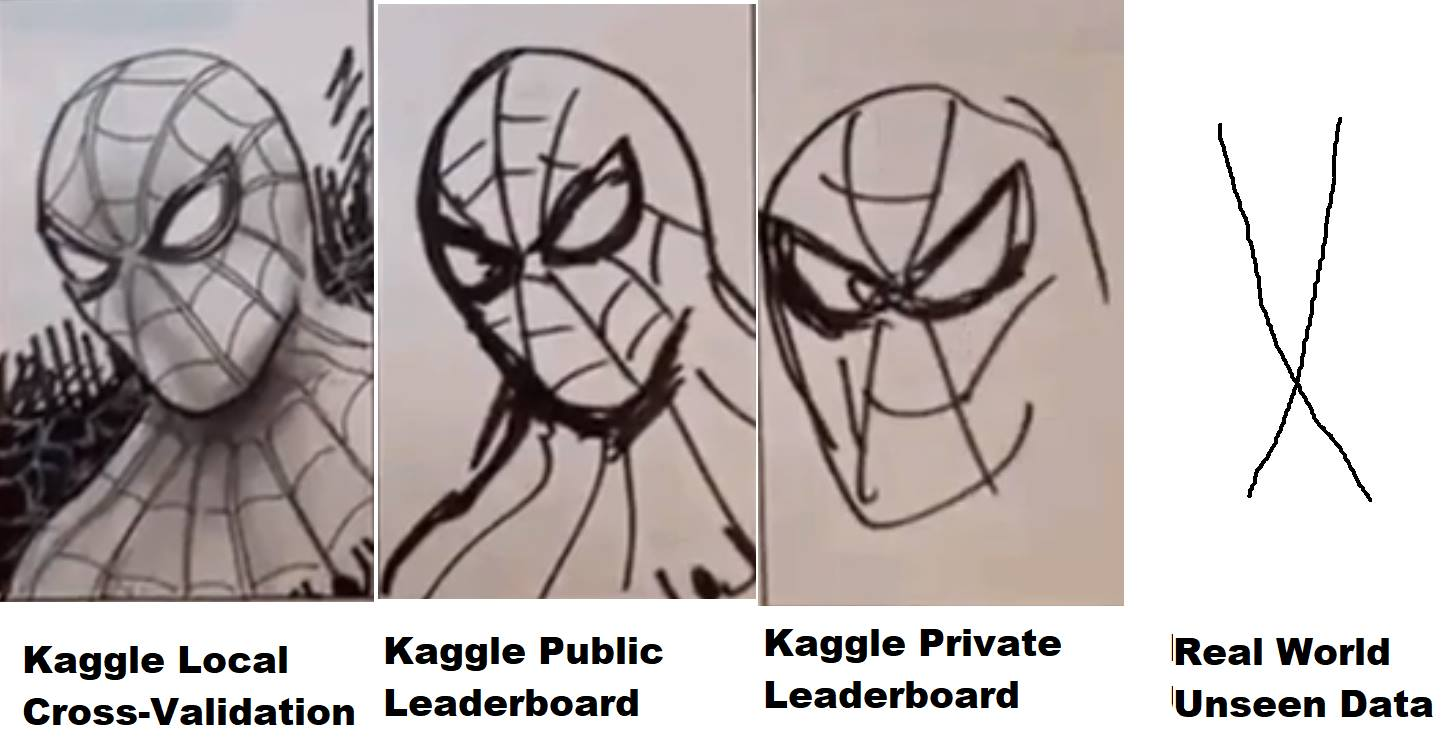